# EDA: ...

...

## 1. Setup

Importamos las librerías necesarias para el análisis: 

In [148]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import folium
import contextily as ctx

Configuraciones generales:

In [149]:
# Estilo general
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")

# Paleta principal
sns.set_palette(sns.color_palette([
    "#1f78b4",  # azul agua
    "#33a02c",  # verde agricultura
    "#b15928",  # café tierra
    "#a6cee3",  # azul claro
    "#b2df8a",  # verde claro
]))

# pandas float format
pd.options.display.float_format = '{:.2f}'.format

Definimos las rutas de los directorios de datos: 

In [150]:
# Ruta al directorio de datos
data_dir = Path().resolve().parent / "data"

# Datos procesados
processed_dir = data_dir / "processed"

assert processed_dir.exists() & processed_dir.is_dir()

# Datos eda
eda_dir = data_dir / "eda"

assert eda_dir.exists() & eda_dir.is_dir()


La ruta al  conjunto de datos eda: 

In [154]:
for item in eda_dir.iterdir(): 
    print(item.relative_to(data_dir.parent))

data\eda\agricultura.csv
data\eda\hidricos_1999.csv
data\eda\mpios.geojson


In [155]:
agricultura_path = eda_dir / "agricultura.csv"
hidricos_path = eda_dir / "hidricos_1999.csv"

In [156]:
presas_path = processed_dir / "hidricos" / "presas_processed.csv"

La ruta a los datos georeferenciados de los municipios de Sonora: 

In [157]:
mpios_dir = processed_dir / "mpios"

assert mpios_dir.exists() & mpios_dir.is_dir()

for item in mpios_dir.iterdir(): 
    print(item.relative_to(data_dir.parent))

data\processed\mpios\mpios_processed.geojson


In [158]:
mpios_path = mpios_dir / "mpios_processed.geojson"

Definimos algunos directorios auxiliares: 

In [159]:
temp_dir = data_dir / "temp"
temp_dir.mkdir(exist_ok=True)

## 1.1 Funciones auxiliares

A continuación definimos funcionea auxiliares:

In [160]:
def get_sonora_map():
    sonora_coords = (29.072967, -110.955919)
    return folium.Map(location=sonora_coords, zoom_start=12)

## 2. Datos

### 2.1 Contexto y estado actual

...

### 2.2 Carga de los datos

Definimos el *GeoDataFrame* de cada conjunto de datos:

In [161]:
# agricultura
agricultura = pd.read_csv(agricultura_path, index_col=0)

# hidricos
hidricos = pd.read_csv(hidricos_path, index_col=0)

# presas
presas = pd.read_csv(presas_path, index_col=0)

# municipios
mpios = gpd.read_file(mpios_path, )

...

## EDA

### Tendencias agrícolas

#### ¿Cómo ha evolucionado la superficie sembrada y cosechada en Sonora entre 1999 y 2021?

Agrupamos los datos de superficie sembrada y cosechada por `anio`: 

In [162]:
agricultura.columns

Index(['anio', 'tipo_registro', 'ciclo_productivo', 'distrito_ddr',
       'municipio', 'cultivo', 'superficie_sembrada_ha',
       'superficie_cosechada_ha', 'superficie_siniestrada_ha',
       'produccion_ton', 'rendimiento_ton_ha', 'precio_medio_rural',
       'valor_produccion_miles_mxn', 'cultivo_base'],
      dtype='object')

In [163]:
agg_year = (
    agricultura
    .groupby('anio')
    .agg(
        {
            'superficie_sembrada_ha': 'sum', 
            'superficie_cosechada_ha': 'sum'
        }
    )
    .reset_index()
)
agg_year; 

Calculamos la diferencia entre la superficie sebrada y cosechada: 

In [164]:
agg_year['diferencia'] = agg_year['superficie_sembrada_ha'] - agg_year['superficie_cosechada_ha']
agg_year.to_markdown(temp_dir / "agg_year.md")

La columna `superficie_siniestrada_ha` posee información de la cantidad de hectáreas sembradas que se perdieron debido a algún siniestro.

Definiremos la *"tasa de siniestralidad"* como la cantidad de hectareas afectadas por superficie sembrada: 

In [165]:
siniestralidad = (
    agricultura.groupby('anio')['superficie_siniestrada_ha'].sum()
    / agricultura.groupby('anio')['superficie_sembrada_ha'].sum()
)
siniestralidad; 

In [166]:
# agg_year['tasa_siniestralidad'] = (
#     agricultura.groupby('anio')['superficie_siniestrada_ha'].sum()
#     / agricultura.groupby('anio')['superficie_sembrada_ha'].sum()
# )
# agg_year

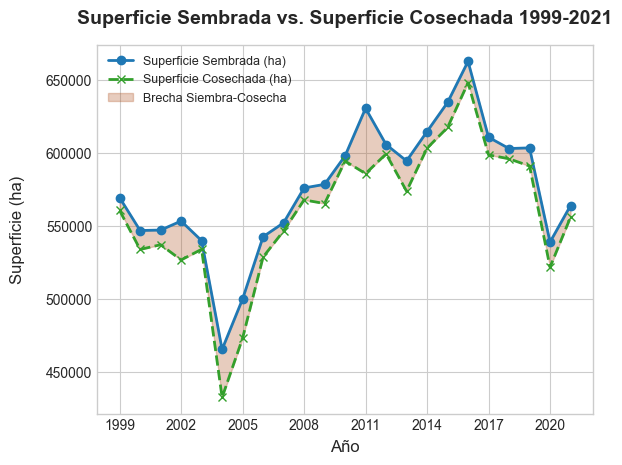

In [167]:
plt.plot(
    agg_year['anio'],
    agg_year['superficie_sembrada_ha'],
    label='Superficie Sembrada (ha)',
    # color='b',
    linewidth=2,
    linestyle='-',
    marker='o'
    )

plt.plot(
    agg_year['anio'],
    agg_year['superficie_cosechada_ha'],
    label='Superficie Cosechada (ha)',
    # color='g',
    linewidth=2,
    linestyle='--',
    marker='x'
)

plt.fill_between(agg_year['anio'], agg_year['superficie_sembrada_ha'], agg_year['superficie_cosechada_ha'], 
                 color="#b15928", alpha=0.3, label='Brecha Siembra-Cosecha')


plt.title('Superficie Sembrada vs. Superficie Cosechada 1999-2021', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Año', fontsize=12, labelpad=5)
plt.ylabel('Superficie (ha)', fontsize=12, labelpad=15)

plt.xticks(list(range(1999, 2021, 3)))

plt.legend(title='', loc='upper left', fontsize=9)

plt.savefig("../plots/superficie_sembrada_cosechada.png")
plt.show()

...

#### ¿Qué cultivos son los más importantes, por superficie, producción o valor?

In [168]:
agricultura.columns

Index(['anio', 'tipo_registro', 'ciclo_productivo', 'distrito_ddr',
       'municipio', 'cultivo', 'superficie_sembrada_ha',
       'superficie_cosechada_ha', 'superficie_siniestrada_ha',
       'produccion_ton', 'rendimiento_ton_ha', 'precio_medio_rural',
       'valor_produccion_miles_mxn', 'cultivo_base'],
      dtype='object')

In [169]:
agg_cult = (
    agricultura
    .groupby('cultivo_base')
    .agg(
        {
            'superficie_sembrada_ha': 'sum', 
            'produccion_ton': 'sum',
            'valor_produccion_miles_mxn': 'sum',  
        }
    )
    .sort_values('superficie_sembrada_ha', ascending=False)
    .reset_index()
)
agg_cult

,cultivo_base,superficie_sembrada_ha,produccion_ton,valor_produccion_miles_mxn
0,trigo,6071549.61,37416340.91,113541303.58
1,sorgo,872404.58,9211455.42,6819927.87
2,maiz,868039.66,6142195.53,18368568.13
3,cartamo,737708.75,1511031.56,6464038.31
4,alfalfa,597705.77,9227238.51,16437412.96
...,...,...,...,...
89,papaya,33.00,162.00,324.00
90,zempoalxochitl,19.50,174.37,908.43
91,maguey pulquero,16.00,0.00,0.00
92,mano de leon,9.50,16714.00,1068.55


Top 25 cultivos más importantes: 

In [170]:
top10 = agg_cult.nlargest(10, 'superficie_sembrada_ha')
top10

,cultivo_base,superficie_sembrada_ha,produccion_ton,valor_produccion_miles_mxn
0,trigo,6071549.61,37416340.91,113541303.58
1,sorgo,872404.58,9211455.42,6819927.87
2,maiz,868039.66,6142195.53,18368568.13
3,cartamo,737708.75,1511031.56,6464038.31
4,alfalfa,597705.77,9227238.51,16437412.96
5,uva,518226.22,6401105.14,106522831.00
6,garbanzo,465533.46,928653.74,10432060.25
7,papa,258972.93,7883435.59,50281134.39
8,esparrago,245659.10,1869872.37,64720114.55
9,algodon,242216.70,815369.88,5469780.16


Convertimos a formato largo

In [171]:
df_long = top10.melt(
    id_vars='cultivo_base',
    value_vars=[
        'superficie_sembrada_ha',
        'produccion_ton',
        'valor_produccion_miles_mxn'
    ],
    var_name='variable',
    value_name='valor'
)

df_long['valor'] = df_long['valor'].replace(0, 1)

df_long; 

Ordenamos valores por...

In [172]:
order = (
    df_long[df_long['variable'] == 'Valor (miles MXN)']
    .sort_values('valor', ascending=False)['cultivo_base']
)

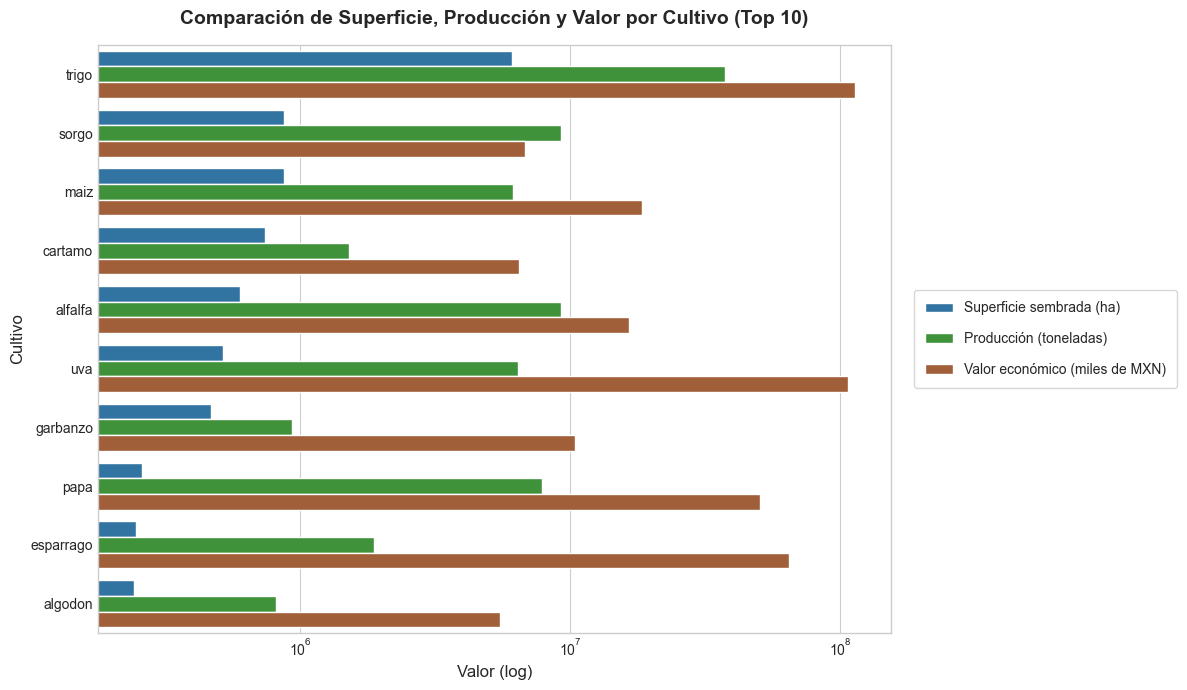

In [188]:
plt.figure(figsize=(12, 7))

sns.barplot(
    data=df_long,
    y='cultivo_base',
    x='valor',
    hue='variable',
    orient='h',
)

plt.title('Comparación de Superficie, Producción y Valor por Cultivo (Top 10)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Valor (log)', fontsize=12)
plt.ylabel('Cultivo', fontsize=12)

plt.xscale('log')

# Renombrar variables para claridad en la leyenda
variable_labels = {
    'superficie_sembrada_ha': 'Superficie sembrada (ha)',
    'produccion_ton': 'Producción (toneladas)',
    'valor_produccion_miles_mxn': 'Valor económico (miles de MXN)'
}
handles, labels = plt.gca().get_legend_handles_labels()
labels = [variable_labels.get(l, l) for l in labels]

plt.legend(
    handles,
    labels,
    title='',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    framealpha=0.8,
    shadow=False,
    borderpad=0.8,
    labelspacing=1.2,
    fontsize=10,
    title_fontsize=11,
)

plt.tight_layout()
plt.savefig("../plots/top_cultivos.png")
plt.show()

...

#### ¿Cuáles cultivos han crecido y cuales han disminuido a lo largo de los años?

In [174]:
year_sup = (
    agricultura
    .groupby(['anio', 'cultivo_base'])['superficie_sembrada_ha']
    .sum()
    .reset_index()
)
year_sup; 

In [175]:
pivot_sup = year_sup.pivot(index='anio', columns='cultivo_base', values='superficie_sembrada_ha')
pivot_sup.to_markdown("../data/temp/pivot_superficie.md")
pivot_sup; 


Consideremos los top 10 cultivos por superficie total: 

In [176]:
top10_cultivos = (
    pivot_sup
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top10_cultivos;  # OK

In [177]:
df_top10 = pivot_sup[top10_cultivos]
df_top10.to_markdown(temp_dir / "top10_evolucion.md")
df_top10;  # OK

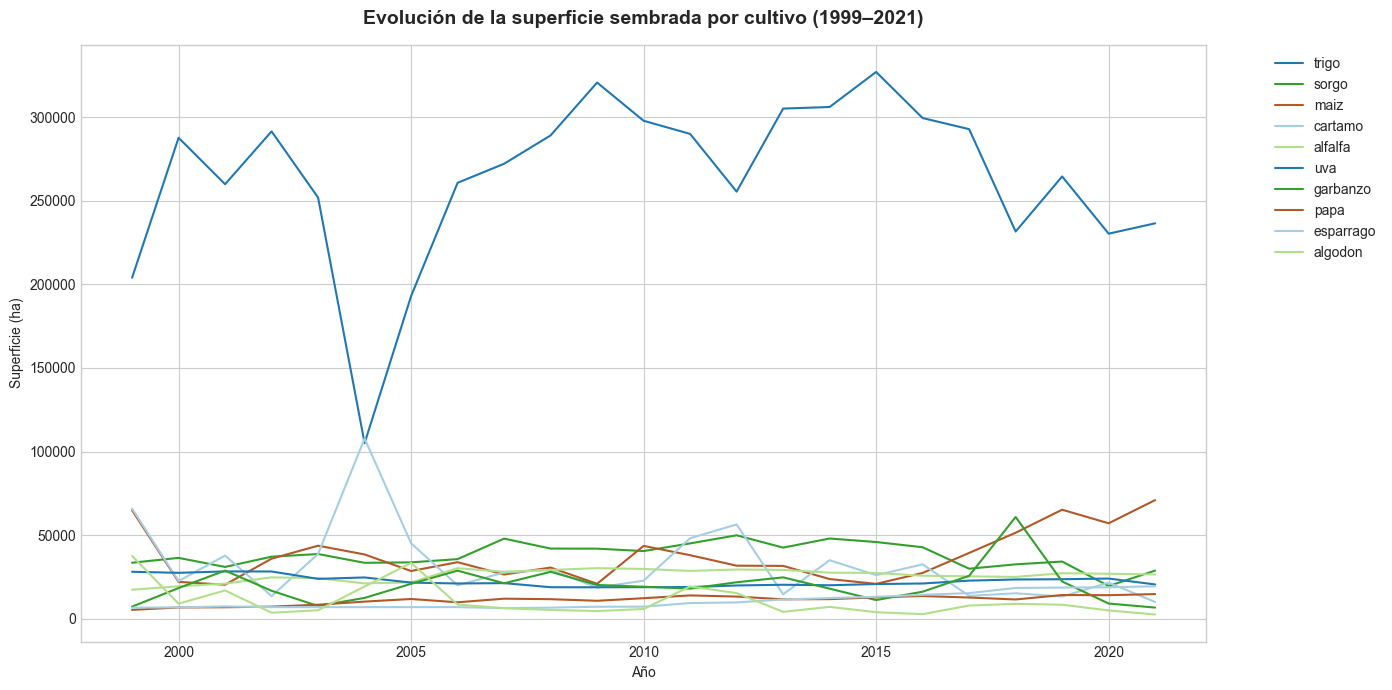

In [189]:
plt.figure(figsize=(14, 7))
for col in df_top10.columns:
    plt.plot(df_top10.index, df_top10[col], label=col)

plt.title('Evolución de la superficie sembrada por cultivo (1999–2021)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Superficie (ha)')
plt.xlabel('Año')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../plots/superficie_sembrada_cultivo.png")
plt.show()

In [180]:
df_change = ((pivot_sup.loc[2021] - pivot_sup.loc[1999]) / pivot_sup.loc[1999] * 100)
df_change = df_change[top10_cultivos].sort_values()
df_change

cultivo_base
algodon     -93.00
cartamo     -84.70
uva         -26.88
sorgo       -14.05
garbanzo     -7.51
maiz          9.38
trigo        15.95
alfalfa      52.47
papa        174.81
esparrago   191.19
dtype: float64

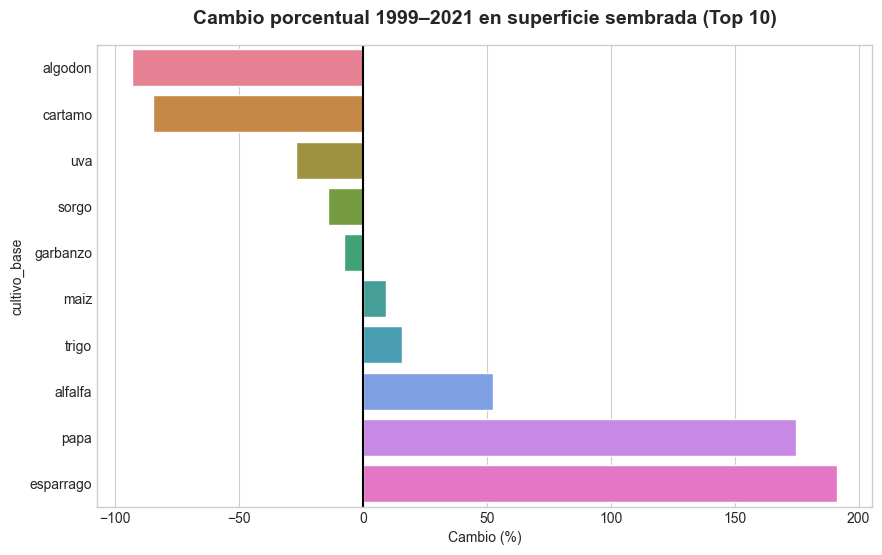

In [190]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df_change, y=df_change.index, hue=df_change.index)
plt.axvline(0, color='black')
plt.title('Cambio porcentual 1999–2021 en superficie sembrada (Top 10)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Cambio (%)')
plt.savefig("../plots/cambio_sup_sembrada.png")
plt.show()

...

### Disponibilidad de agua

In [ ]:
hidricos.head()

,clave,fecha,almacenamiento_hm3,presa,presa_nombre_comun,anio,mes,anio_mes
29583,arlso,1999-01-01,1.63,abelardo rodríguez luján,hermosillo,1999,1,1999-1
29584,pmoso,1999-01-01,6.59,ing. rodolfo félix valdés,el molinito,1999,1,1999-1
29585,arcso,1999-01-01,331.73,adolfo ruiz cortines,mocúzari,1999,1,1999-1
29586,agzch,1999-01-01,62.08,abraham gonzález,guadalupe,1999,1,1999-1
29587,aobso,1999-01-01,918.25,álvaro obregón,oviachic,1999,1,1999-1


#### ¿Cómo han cambiado los niveles de almacenamiento en las presas?

Agrupamos por año y presa:

In [122]:
agua_year = (
    hidricos
    .groupby(['anio', 'presa'])['almacenamiento_hm3']
    .mean()
    .reset_index()
)
agua_year.head();  # OK

Agrupamos por año:

In [145]:
agua_state = (
    agua_year
    .groupby('anio')['almacenamiento_hm3']
    .sum()
    .reset_index()
)
agua_state; 

La tabla anterior muestra la cantidad de agua que estuvo disponible en promedio para cada año. 

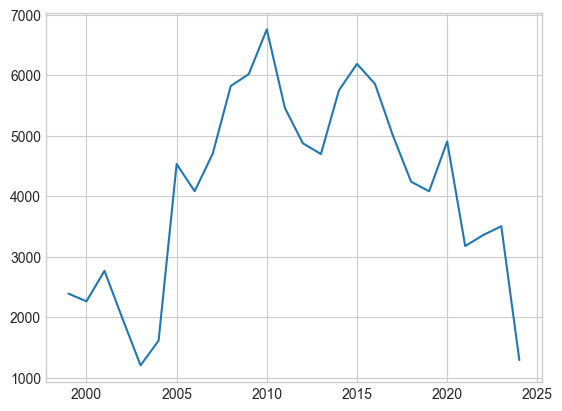

In [132]:
plt.plot(agua_state['anio'], agua_state['almacenamiento_hm3'])
plt.show()

* Caída fuerte enrte 2001-2004 (periodo de sequía severa)
* Recuperación parcial de 2008-2010
* Sequía importante a partir de 2019

Analicemos las estadísticas del almacenamiento histórico: 

In [134]:
agua_state['almacenamiento_hm3'].describe()

count     26.00
mean    4095.64
std     1618.74
min     1203.52
25%     2868.67
50%     4385.47
75%     5343.39
max     6758.02
Name: almacenamiento_hm3, dtype: float64

* El **50%** de los datos posee almacenamiento de 4385 hm3. 

Durante periodos de sequía (2001-2004 & 2019-2021) el almacenamiento disponible fue de 3000 hm3. Podemos definir este valor como umbral para identificar periodos de sequía. 

In [ ]:
threshold = agua_state['almacenamiento_hm3'] < 3000

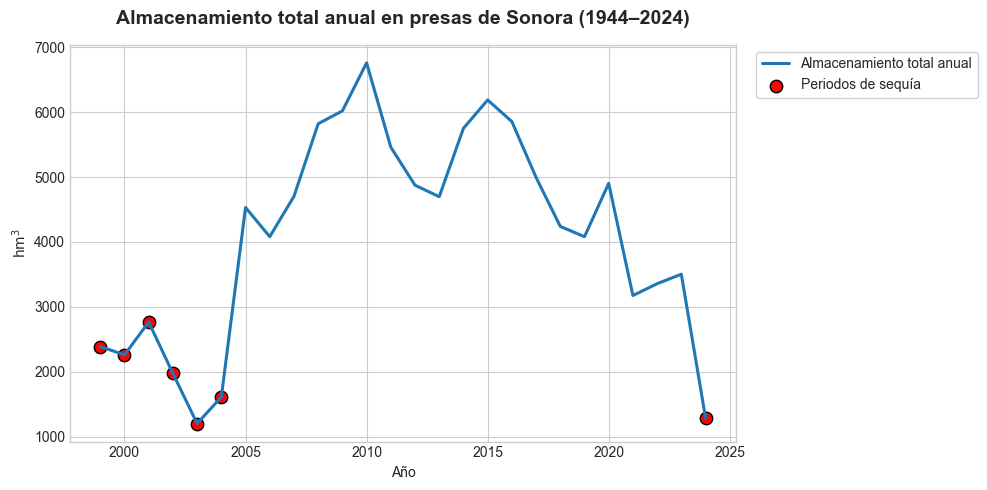

In [191]:
plt.figure(figsize=(10,5))

plt.plot(
    agua_state['anio'],
    agua_state['almacenamiento_hm3'],
    linewidth=2.2,
    label='Almacenamiento total anual'
)

plt.scatter(
    agua_state['anio'][threshold],
    agua_state['almacenamiento_hm3'][threshold],
    color='red',
    edgecolor='black',
    s=80,
    label='Periodos de sequía'
)

plt.title('Almacenamiento total anual en presas de Sonora (1944–2024)', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('$\\text{hm}^3$')
plt.xlabel('Año')

plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=True,
    framealpha=0.9
)

plt.tight_layout()
plt.savefig("../plots/disponibilidad_agua_anual.png")
plt.show()

...

#### ¿Cómo se conectan los ciclos hídricos con la actividad agrícola?

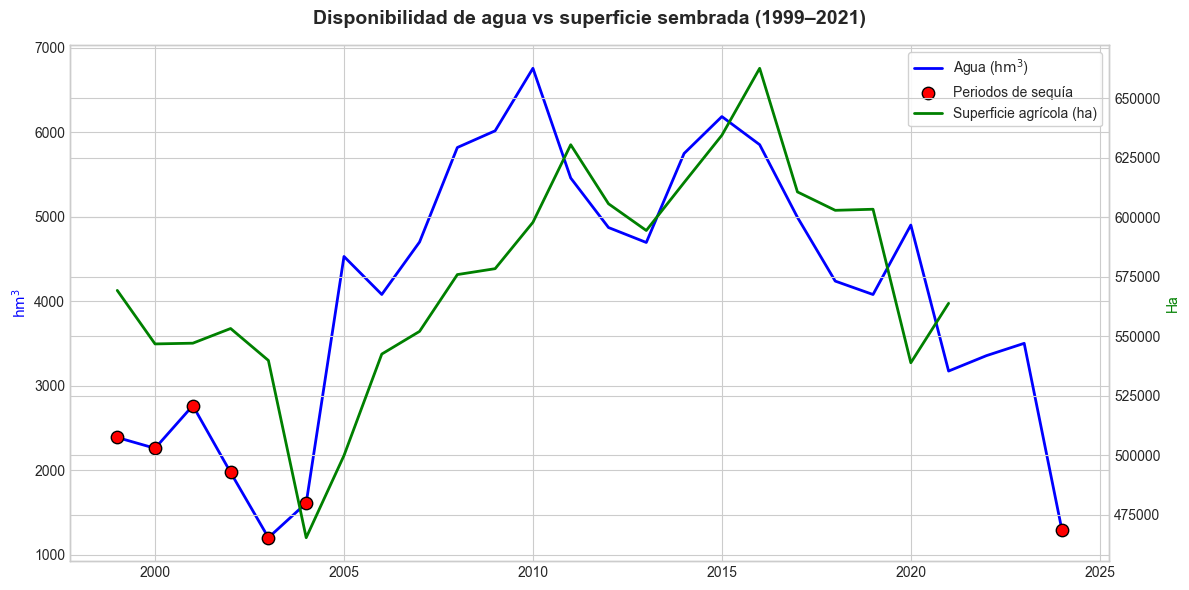

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Serie 1: Agua
line1, = ax1.plot(
    agua_state['anio'],
    agua_state['almacenamiento_hm3'],
    color='blue',
    linewidth=2,
    label='Agua ($\\text{hm}^3$)'
)
ax1.set_ylabel("$\\text{hm}^3$", color='blue')

# Scatter sequia
scatter = ax1.scatter(
    agua_state['anio'][threshold],
    agua_state['almacenamiento_hm3'][threshold],
    color='red',
    edgecolor='black',
    s=80,
    zorder=5,
    label='Periodos de sequía'
)

# Serie 2: Superficie agrícola
ax2 = ax1.twinx()
line2, = ax2.plot(
    agg_year['anio'],
    agg_year['superficie_sembrada_ha'],
    color='green',
    linewidth=2,
    label='Superficie agrícola (ha)'
)
ax2.set_ylabel('Ha', color='green')

# ---- Título ----
plt.title(
    'Disponibilidad de agua vs superficie sembrada (1999–2021)',
    fontsize=14,
    fontweight='bold',
    pad=15
)

# ---- Leyenda unificada ----
lines = [line1, scatter, line2]
labels = [l.get_label() for l in lines]

ax1.legend(
    lines,
    labels,
    loc='upper right',
    frameon=True,
    framealpha=0.9
)

plt.tight_layout()
plt.savefig("../plots/disponibilidad_agua_sup_sembrada.png")
plt.show()


...

## Conclusiones

...